# Jira HADOOP data analysis

In [1]:
import json
from itertools import chain
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data/hadoop_issues.json') as f:
    issues = json.load(f)
issues = issues['issues']

In [3]:
with open('data/hadoop_issues_comments.json') as f:
    comments = json.load(f)

## Important attributes (Per Issue)

In [4]:
issues[0]['id'], issues[0]['key'], \
issues[0]['fields']['issuetype']['name'], \
issues[0]['fields']['issuetype']['subtask'], \
issues[0]['fields']['timespent'], \
issues[0]['fields']['project']['id'], issues[0]['fields']['project']['key'], \
issues[0]['fields']['aggregatetimespent'], issues[0]['fields']['resolution']['name'], \
issues[0]['fields']['resolutiondate'], issues[0]['fields']['lastViewed'], \
issues[0]['fields']['watches']['watchCount'], issues[0]['fields']['created'], \
issues[0]['fields']['priority']['name'], issues[0]['fields']['labels'], \
issues[0]['fields']['timeestimate'], issues[0]['fields']['aggregatetimeoriginalestimate'], \
issues[0]['fields']['issuelinks'][0]['type']['inward'], \
issues[0]['fields']['issuelinks'][0]['type']['outward'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['key'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['fields']['summary'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['fields']['status']['statusCategory']['name'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['fields']['priority']['name'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['fields']['issuetype']['name'], \
issues[0]['fields']['issuelinks'][0]['outwardIssue']['fields']['issuetype']['subtask'], \
issues[0]['fields']['assignee']['key'], issues[0]['fields']['updated'], \
issues[0]['fields']['status']['name'], issues[0]['fields']['components'][0]['name'], \
issues[0]['fields']['timeoriginalestimate'], issues[0]['fields']['description'], \
issues[0]['fields']['aggregatetimeestimate'], issues[0]['fields']['summary'], \
issues[0]['fields']['creator']['key'], issues[0]['fields']['subtasks'], \
issues[0]['fields']['reporter']['key'], issues[0]['fields']['aggregateprogress']['progress'], \
issues[0]['fields']['aggregateprogress']['total'], issues[0]['fields']['duedate'], \
issues[0]['fields']['progress']['progress'], issues[0]['fields']['progress']['total'], \
issues[0]['fields']['votes']['votes']

('13203378',
 'HADOOP-15994',
 'Improvement',
 False,
 None,
 '12310240',
 'HADOOP',
 None,
 'Fixed',
 '2018-12-10T14:17:17.000+0000',
 None,
 1,
 '2018-12-10T09:12:49.000+0000',
 'Major',
 [],
 None,
 None,
 'is related to',
 'relates to',
 'HADOOP-9991',
 'Fix up Hadoop POMs, roll up JARs to latest versions',
 'To Do',
 'Major',
 'Improvement',
 False,
 'jack-lee',
 '2018-12-10T14:17:17.000+0000',
 'Resolved',
 'security',
 None,
 "Now Jackson 2.9.5 is used and it is vulnerable (CVE-2018-11307). Let's upgrade to 2.9.6 or upper.",
 None,
 'Upgrade Jackson2 to the latest version',
 'ajisakaa',
 [],
 'ajisakaa',
 0,
 0,
 None,
 0,
 0,
 0)

## Attributes' categorical values

### Issues' type values

In [5]:
type_values = set(issue['fields']['issuetype']['name'] for issue in issues)
type_values

{'Bug', 'Improvement', 'New Feature', 'Sub-task', 'Task', 'Test', 'Wish'}

### Issues' resolution values

In [6]:
set(issue['fields']['resolution']['name'] if issue['fields']['resolution'] else 'NONE_VALUE' for issue in issues)

{'Cannot Reproduce',
 'Done',
 'Duplicate',
 'Fixed',
 'Implemented',
 'Invalid',
 'NONE_VALUE',
 'Not A Bug',
 'Not A Problem',
 'Resolved',
 "Won't Fix"}

### Issues' importance/priority values

In [7]:
priority_values = set(issue['fields']['priority']['name'] for issue in issues)
priority_values

{'Blocker', 'Critical', 'Major', 'Minor', 'Trivial'}

### Issues' label values

In [8]:
label_values = set(chain.from_iterable(issue['fields']['labels'] for issue in issues))
label_values

{'BB2015-05-TBR',
 'GraphiteSink,',
 'IPv6',
 'Java9',
 'KeyStore',
 'Security',
 'WASB',
 'Windows',
 'bash',
 'build',
 'common',
 'distcp',
 'docker',
 'docuentation',
 'documentation',
 'easy-fix',
 'easyfix',
 'features',
 'filesystem',
 'flaky-test',
 'fs',
 'hadoop-tools',
 'incompatibleChange',
 'javadoc',
 'jdk9',
 'kms',
 'log',
 'metrics',
 'newbie',
 'patch',
 'performance',
 'security',
 'shell-script',
 'statistics',
 'supportability',
 'tpm',
 'trunk',
 'wavefront',
 'windows'}

### Issues' dependency values

In [9]:
set(issuelink['type']['inward'] for issue in issues for issuelink in issue['fields']['issuelinks'])

{'Blocked',
 'Dependent',
 'Is contained by',
 'is a child of',
 'is blocked by',
 'is broken by',
 'is caused by',
 'is cloned by',
 'is depended upon by',
 'is duplicated by',
 'is part of',
 'is related to',
 'is required by',
 'is superceded by'}

In [10]:
set(issuelink['type']['outward'] for issue in issues for issuelink in issue['fields']['issuelinks'])

{'Blocked',
 'Dependent',
 'blocks',
 'breaks',
 'causes',
 'contains',
 'depends upon',
 'duplicates',
 'incorporates',
 'is a clone of',
 'is a parent of',
 'relates to',
 'requires',
 'supercedes'}

### Dependent Issues' status values

In [11]:
set(issuelink['outwardIssue']['fields']['status']['statusCategory']['name'] if issuelink.get('outwardIssue', None) else issuelink['inwardIssue']['fields']['status']['statusCategory']['name'] for issue in issues for issuelink in issue['fields']['issuelinks'])

{'Done', 'In Progress', 'To Do'}

### Dependent Issues' importance/priority values

In [12]:
set(issuelink['outwardIssue']['fields']['priority']['name'] if issuelink.get('outwardIssue', None) else issuelink['inwardIssue']['fields']['priority']['name'] for issue in issues for issuelink in issue['fields']['issuelinks'])

{'Blocker', 'Critical', 'Major', 'Minor', 'Trivial'}

### Issues' status values

In [13]:
set(issue['fields']['status']['name'] for issue in issues)

{'Closed', 'In Progress', 'Open', 'Patch Available', 'Reopened', 'Resolved'}

In [14]:
issues[0]['fields']['timespent']

In [15]:
columns = {
    'is_subtask': [issue['fields']['issuetype']['subtask'] for issue in issues],
    'status': [issue['fields']['status']['name'] for issue in issues],
    'time_spent': [issue['fields']['timespent'] for issue in issues],
    'aggregate_time_spent': [issue['fields']['aggregatetimespent'] for issue in issues],
    'resolution_date': [issue['fields']['resolutiondate'] for issue in issues],
    'last_viewed': [issue['fields']['lastViewed'] for issue in issues],
    'number_of_watchers': [issue['fields']['watches']['watchCount'] for issue in issues],
    'created': [issue['fields']['created'] for issue in issues],
    'priority': [issue['fields']['priority']['name'] for issue in issues],
    'number_of_labels': [len(issue['fields']['labels']) for issue in issues],
    'time_estimate': [issues[0]['fields']['timeestimate'] for issue in issues],
    'aggregate_time_original_estimate': [issue['fields']['aggregatetimeoriginalestimate'] for issue in issues],
    'number_of_issue_links': [len(issue['fields']['issuelinks']) for issue in issues],
    'updated': [issue['fields']['updated'] for issue in issues],
    'time_original_estimate': [issue['fields']['timeoriginalestimate'] for issue in issues],
    'description': [issue['fields']['description'] for issue in issues],
    'number_of_description_words': [len(issue['fields']['description'].split()) if issue['fields']['description'] else 0 for issue in issues],
    'length_of_description': [len(issue['fields']['description']) if issue['fields']['description'] else 0 for issue in issues],
    'aggregate_time_estimate': [issue['fields']['aggregatetimeestimate'] for issue in issues],
    'summary': [issue['fields']['summary'] for issue in issues],
    'number_of_summary_words': [len(issue['fields']['summary'].split()) for issue in issues],
    'length_of_summary': [len(issue['fields']['summary']) for issue in issues],
    'number_of_subtasks': [len(issue['fields']['subtasks']) for issue in issues],
    'aggregate_progress': [issue['fields']['aggregateprogress']['progress'] for issue in issues],
    'aggregate_progress_total': [issue['fields']['aggregateprogress']['total'] for issue in issues],
    'due_date': [issue['fields']['duedate'] for issue in issues],
    'progress': [issue['fields']['progress']['progress'] for issue in issues],
    'number_of_votes': [issue['fields']['votes']['votes'] for issue in issues],
}

In [16]:
issues_df = pd.DataFrame.from_dict(columns)

## Statistics (mean, std, unique values, plots)

### Number of votes

In [17]:
issues_df['number_of_votes'].describe()

count    1000.000000
mean        0.025000
std         0.224556
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: number_of_votes, dtype: float64

In [18]:
issues_df['number_of_votes'].value_counts()

0    981
1     17
5      1
3      1
Name: number_of_votes, dtype: int64

Text(0, 0.5, 'number of issues')

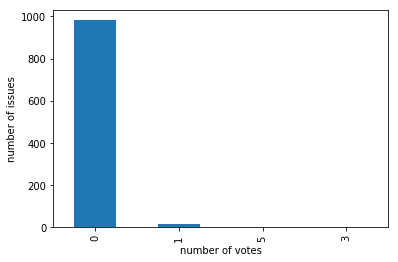

In [19]:
ax = issues_df['number_of_votes'].value_counts().plot(kind='bar')
ax.set_xlabel('number of votes')
ax.set_ylabel('number of issues')

### Number of watchers

In [20]:
issues_df['number_of_watchers'].describe()

count    1000.000000
mean        4.332000
std         3.143829
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        42.000000
Name: number_of_watchers, dtype: float64

In [21]:
issues_df['number_of_watchers'].value_counts()

3     203
4     191
2     157
5     110
1      95
6      93
7      49
8      33
10     18
9      17
12      7
11      6
18      3
15      3
14      3
13      3
0       2
16      2
30      1
17      1
24      1
27      1
42      1
Name: number_of_watchers, dtype: int64

Text(0, 0.5, 'number of issues')

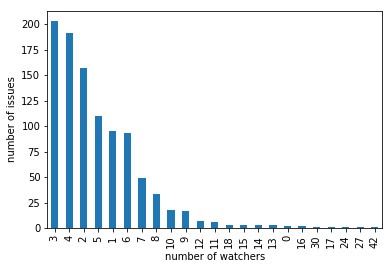

In [22]:
ax = issues_df['number_of_watchers'].value_counts().plot(kind='bar')
ax.set_xlabel('number of watchers')
ax.set_ylabel('number of issues')

### Is subtask?

In [23]:
issues_df['is_subtask'].describe()

count      1000
unique        2
top       False
freq        658
Name: is_subtask, dtype: object

In [24]:
issues_df['is_subtask'].value_counts()

False    658
True     342
Name: is_subtask, dtype: int64

Text(0, 0.5, 'number of issues')

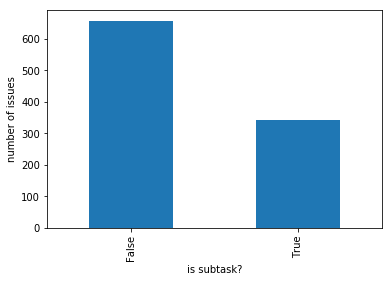

In [25]:
ax = issues_df['is_subtask'].value_counts().plot(kind='bar')
ax.set_xlabel('is subtask?')
ax.set_ylabel('number of issues')

### Status

In [26]:
issues_df['status'].describe()

count         1000
unique           6
top       Resolved
freq           587
Name: status, dtype: object

In [27]:
issues_df['status'].value_counts()

Resolved           587
Open               292
Patch Available    108
In Progress          5
Reopened             4
Closed               4
Name: status, dtype: int64

Text(0, 0.5, 'number of issues')

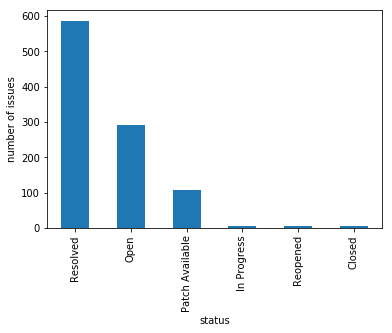

In [28]:
ax = issues_df['status'].value_counts().plot(kind='bar')
ax.set_xlabel('status')
ax.set_ylabel('number of issues')

### Priority

In [29]:
issues_df['priority'].describe()

count      1000
unique        5
top       Major
freq        630
Name: priority, dtype: object

In [30]:
issues_df['priority'].value_counts()

Major       630
Minor       243
Blocker      47
Critical     46
Trivial      34
Name: priority, dtype: int64

Text(0, 0.5, 'number of issues')

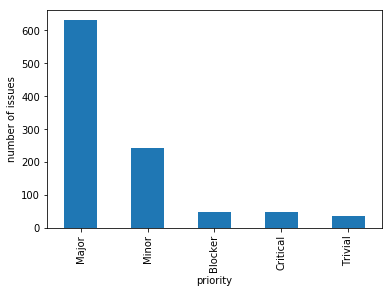

In [31]:
ax = issues_df['priority'].value_counts().plot(kind='bar')
ax.set_xlabel('priority')
ax.set_ylabel('number of issues')

### Number of labels

In [32]:
issues_df['number_of_labels'].describe()

count    1000.000000
mean        0.076000
std         0.346907
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: number_of_labels, dtype: float64

In [33]:
issues_df['number_of_labels'].value_counts()

0    942
1     46
2      7
3      4
4      1
Name: number_of_labels, dtype: int64

Text(0, 0.5, 'number of issues')

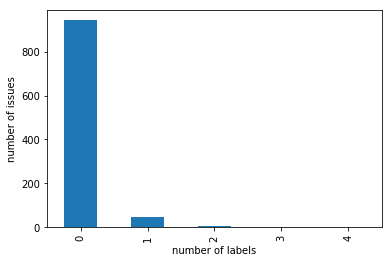

In [34]:
ax = issues_df['number_of_labels'].value_counts().plot(kind='bar')
ax.set_xlabel('number of labels')
ax.set_ylabel('number of issues')

### Number of issue_links

In [35]:
issues_df['number_of_issue_links'].describe()

count    1000.000000
mean        0.858000
std         2.686085
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        74.000000
Name: number_of_issue_links, dtype: float64

In [36]:
issues_df['number_of_issue_links'].value_counts()

0     555
1     273
2      97
3      42
4      14
5       7
9       3
6       3
11      2
74      1
18      1
8       1
7       1
Name: number_of_issue_links, dtype: int64

Text(0, 0.5, 'number of issue links')

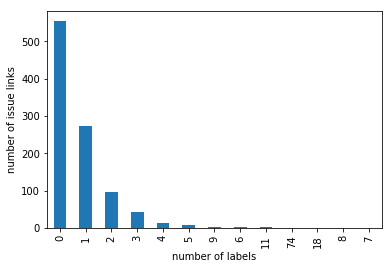

In [37]:
ax = issues_df['number_of_issue_links'].value_counts().plot(kind='bar')
ax.set_xlabel('number of labels')
ax.set_ylabel('number of issue links')

### Number of description words

In [38]:
issues_df['number_of_description_words'].describe()

count    1000.000000
mean       80.737000
std        98.579825
min         0.000000
25%        27.000000
50%        52.500000
75%       100.000000
max      1177.000000
Name: number_of_description_words, dtype: float64

In [39]:
pd.cut(issues_df['number_of_description_words'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 1200], include_lowest=True).value_counts()

(100.0, 200.0]      171
(20.0, 30.0]        118
(10.0, 20.0]        107
(40.0, 50.0]         98
(30.0, 40.0]         93
(-0.001, 10.0]       71
(50.0, 60.0]         70
(60.0, 70.0]         60
(70.0, 80.0]         58
(80.0, 90.0]         42
(90.0, 100.0]        39
(200.0, 300.0]       38
(300.0, 400.0]       20
(500.0, 1000.0]      10
(400.0, 500.0]        4
(1000.0, 1200.0]      1
Name: number_of_description_words, dtype: int64

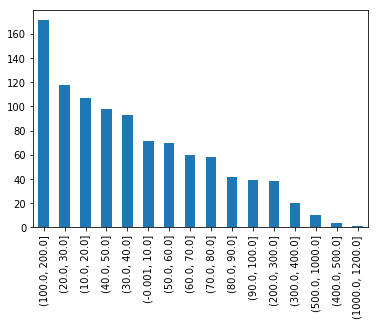

In [40]:
pd.cut(issues_df['number_of_description_words'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 1200], include_lowest=True).value_counts().plot(kind='bar')

### Number of summary words

In [41]:
issues_df['number_of_summary_words'].describe()

count    1000.000000
mean        7.651000
std         2.922283
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        20.000000
Name: number_of_summary_words, dtype: float64

In [42]:
issues_df['number_of_summary_words'].value_counts()

6     141
7     126
5     124
8     123
9     110
10     83
4      70
11     62
3      44
12     40
13     31
14     14
2      11
15      9
16      7
1       2
18      1
17      1
20      1
Name: number_of_summary_words, dtype: int64

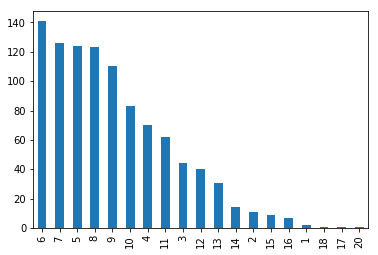

In [43]:
issues_df['number_of_summary_words'].value_counts().plot(kind='bar')

### Number of subtasks

In [44]:
issues_df['number_of_subtasks'].describe()

count    1000.000000
mean        0.379000
std         4.649837
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       116.000000
Name: number_of_subtasks, dtype: float64

In [45]:
issues_df['number_of_subtasks'].value_counts()

0      985
116      1
48       1
43       1
32       1
31       1
30       1
27       1
14       1
13       1
10       1
5        1
4        1
3        1
2        1
1        1
Name: number_of_subtasks, dtype: int64

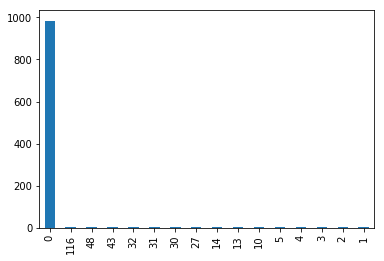

In [46]:
issues_df['number_of_subtasks'].value_counts().plot(kind='bar')

### What about due dates, times and progress status?!

#### Only 2 out of 1000 due dates are not null!

In [47]:
issues_df['due_date'].value_counts()

2018-02-28    1
2018-05-07    1
Name: due_date, dtype: int64

#### 1000 out of 1000 progress are null!

In [48]:
issues_df['progress'].value_counts()

0    1000
Name: progress, dtype: int64

#### 8 out of 1000 issues have a time estimation!

In [49]:
issues_df['time_original_estimate'].value_counts()

345600.0     2
7257600.0    1
3600.0       1
1814400.0    1
60.0         1
300.0        1
0.0          1
Name: time_original_estimate, dtype: int64

In [50]:
issues_df[['due_date', 'progress', 'status', 'time_spent', 'time_estimate', 'time_original_estimate', 'aggregate_time_estimate']].describe(include='all')

,due_date,progress,status,time_spent,time_estimate,time_original_estimate,aggregate_time_estimate
count,2,1000.0,1000,0.0,0.0,8.000000e+00,1.000000e+01
unique,2,NaN,6,0.0,0.0,NaN,NaN
top,2018-02-28,NaN,Resolved,NaN,NaN,NaN,NaN
freq,1,NaN,587,NaN,NaN,NaN,NaN
mean,NaN,0.0,NaN,NaN,NaN,1.220895e+06,9.785160e+05
std,NaN,0.0,NaN,NaN,NaN,2.515069e+06,2.276179e+06
min,NaN,0.0,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,NaN,0.0,NaN,NaN,NaN,2.400000e+02,1.125000e+03
50%,NaN,0.0,NaN,NaN,NaN,1.746000e+05,9.000000e+03
75%,NaN,0.0,NaN,NaN,NaN,7.128000e+05,3.456000e+05


## Example

### Find similar issues - Cluster issues (using k-means or nearest neighbors algorithm)

In [51]:
# Preparing data. Generating features.
people = set([issue['fields']['reporter']['key'] for issue in issues] + [issue['fields']['assignee']['key'] for issue in issues if issue['fields']['assignee']] + 
             sum([[comment['author']['key'] for comment in comments[issue['key']]] for issue in issues], []))
people.remove('hadoop3')
people.remove('hadoopqa')
people = sorted(list(people))
priority_values_list = sorted([item.lower().strip() for item in list(priority_values)])
issue_labels_list = sorted([item.lower().strip() for item in list(label_values)])
type_values_list = sorted([item.lower().strip() for item in list(type_values)])

In [52]:
# Generating features (columns attribute).
for issue in issues:
    assignee = [issue['fields']['assignee']['key']] if issue['fields']['assignee'] else []
    issue['user_columns'] = [('user_%s'% (person), 1 if person in assignee + [issue['fields']['reporter']['key']] + [comment['author']['key'] for comment in comments[issue['key']]]  else 0)  for person in people]
    issue['priority_columns'] = [('priority_%s' % (priority), 1 if issue['fields']['priority']['name'].lower().strip() == priority else 0) for priority in priority_values_list]
    issue['label_columns'] = [('label_%s' % (label), 1 if label in [item.lower().strip() for item in issue['fields']['labels']] else 0) for label in issue_labels_list]
    issue['type_columns'] = [('type_%s' % (type_value), 1 if type_value == issue['fields']['issuetype']['name'].lower().strip() else 0) for type_value in type_values_list]
    issue['columns'] = issue['user_columns'] + issue['priority_columns'] + issue['label_columns'] + issue['type_columns']

### K-Means algorithm

In [53]:
# Use the last issue as a test.
X = [[column[1] for column in issue['columns']] for issue in issues]
test_issue = X[-1]
print('Test issue: %s' % (issues[-1]['key']))
X = np.array(X[:-1])
# Implement the 'Elbow' method.
# WCSS = (within-cluster sums of squares).
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

Test issue: HADOOP-14960


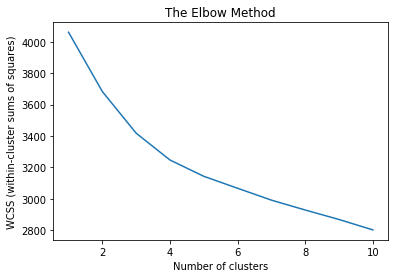

In [54]:
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (within-cluster sums of squares)')
plt.show()

4 or 5 number of clusters looks good, according to the elbow plot. Let's use **5**. Furthermore, the number of priority categories is also 5. 

In [55]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
group_of_test_issue = kmeans.predict([test_issue])[0]

In [56]:
group_positions = np.nonzero(kmeans.labels_ == group_of_test_issue)[0]

### Nearest Neighbors algorithm

In [57]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(X)
k_nearest_positions = neigh.kneighbors([test_issue], return_distance=False)[0]

### Recommend users which can help with the test issue

In [58]:
def recommend_users(positions, number_of_users=10):
    group_issues = [issues[index] for index in positions]
    occurrence_of_users = np.sum([[column[1] for column in issue['user_columns']] for issue in group_issues], axis=0)
    best_users_positions = occurrence_of_users.argsort()[-number_of_users:][::-1]
    for index in best_users_positions:
        print('Contact user "%s" in order to help.' % (group_issues[0]['user_columns'][index][0].split('user_')[1]))

In [59]:
recommend_users(group_positions)

Contact user "genericqa" in order to help.
Contact user "hudson" in order to help.
Contact user "stevel@apache.org" in order to help.
Contact user "ajisakaa" in order to help.
Contact user "xiaochen" in order to help.
Contact user "jojochuang" in order to help.
Contact user "arpitagarwal" in order to help.
Contact user "ajayydv" in order to help.
Contact user "sunilg" in order to help.
Contact user "elgoiri" in order to help.


In [60]:
recommend_users(k_nearest_positions)

Contact user "xiaochen" in order to help.
Contact user "hudson" in order to help.
Contact user "genericqa" in order to help.
Contact user "xkrogen" in order to help.
Contact user "arpitagarwal" in order to help.
Contact user "kihwal" in order to help.
Contact user "rkanter" in order to help.
Contact user "csun" in order to help.
Contact user "xyao" in order to help.
Contact user "haibochen" in order to help.
